In [1]:
import numpy as np
import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import shutil

# ! pip install split-folders
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt

rs = 42
def reset_random_seeds(rs):
   os.environ['PYTHONHASHSEED']=str(rs)
   tf.random.set_seed(rs)
   np.random.seed(rs)
   random.seed(rs)
reset_random_seeds(rs)

remove prev saved database:

In [2]:
dir_path = './data/humanModel/dataset_v0_split'
if os.path.exists(dir_path):
    shutil.rmtree(dir_path)
else:
    print("File not found in the directory")

# Part 1 - Data Preprocessing

## Split into train , test data

In [3]:
# train, test split
splitfolders.ratio('./data/humanModel/dataset_v0/', output=dir_path, ratio=(0.85, 0.15))

Copying files: 8160 files [00:00, 17060.46 files/s]


### Preprocessing the Training set

In [4]:
batch_size = 128
IMG_SIZE = 5

datagen = ImageDataGenerator(rescale = 1./255)
train = datagen.flow_from_directory((dir_path+'/train'),
                                          target_size = (IMG_SIZE,IMG_SIZE), batch_size = batch_size, seed=rs, class_mode='sparse')

test = datagen.flow_from_directory((dir_path+'/val'),
                                            target_size = (IMG_SIZE, IMG_SIZE), batch_size = batch_size, seed=rs, class_mode='sparse')

Found 6934 images belonging to 4 classes.
Found 1226 images belonging to 4 classes.


## View some data

In [5]:
num_classes = 4

model = Sequential([
  layers.Conv2D(4, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=[IMG_SIZE,IMG_SIZE,3]),
  layers.Conv2D(8, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  # layers.MaxPooling2D(),
  layers.Conv2D(8, 2, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
  layers.Dense(num_classes, activation='softmax')
])

In [6]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 5, 5, 4)           112       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 8)           296       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 8)           264       
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                12864     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2

In [8]:
epochs=175
history = model.fit(
  train,
  validation_data=test,
  epochs=epochs
)

Epoch 1/175
55/55 [==============================] - 2s 19ms/step - loss: 1.4693 - accuracy: 0.2870 - val_loss: 1.4399 - val_accuracy: 0.3140
Epoch 2/175
55/55 [==============================] - 1s 15ms/step - loss: 1.4128 - accuracy: 0.3187 - val_loss: 1.3545 - val_accuracy: 0.3891
Epoch 3/175
55/55 [==============================] - 1s 15ms/step - loss: 1.3289 - accuracy: 0.3976 - val_loss: 1.2665 - val_accuracy: 0.4356
Epoch 4/175
55/55 [==============================] - 1s 15ms/step - loss: 1.2705 - accuracy: 0.4445 - val_loss: 1.2222 - val_accuracy: 0.4715
Epoch 5/175
55/55 [==============================] - 1s 15ms/step - loss: 1.2421 - accuracy: 0.4448 - val_loss: 1.2055 - val_accuracy: 0.4796
Epoch 6/175
55/55 [==============================] - 1s 16ms/step - loss: 1.2184 - accuracy: 0.4650 - val_loss: 1.1772 - val_accuracy: 0.4910
Epoch 7/175
55/55 [==============================] - 1s 16ms/step - loss: 1.2071 - accuracy: 0.4680 - val_loss: 1.1725 - val_accuracy: 0.5000
Epoch 

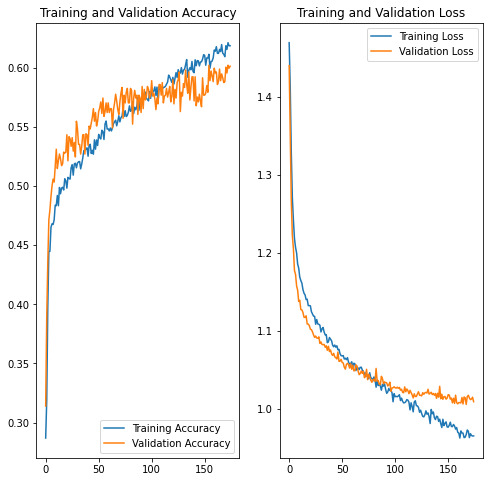

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
loss, accuracy = model.evaluate(test)
print('Test accuracy :', accuracy)

10/10 [==============================] - 0s 12ms/step - loss: 1.0092 - accuracy: 0.6011
Test accuracy : 0.6011419296264648


In [11]:
# Save the weights model.
model.save('./data/humanModel/model_v0.h5')

In [12]:
# save model in js format
# import tensorflowjs as tfjs
# tfjs.converters.save_keras_model(model, 'data/humanModel/js_model_v0')

In [13]:
# new_model = tf.keras.models.load_model('./data/humanModel/mode_v0')

# # Check its architecture
# new_model.summary()

### Predict on new data

In [14]:
path = "./data/humanModel_v0_dataset_split/val/38/-Mr4e3Fomo72jz0zfTgB_14.png"

img = keras.preprocessing.image.load_img(
    path, target_size=(IMG_SIZE, IMG_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array = img_array/255
predictions = model.predict(img_array)[0]

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(np.argmax(predictions), 100 * np.max(predictions))
)

FileNotFoundError: [Errno 2] No such file or directory: './data/humanModel_v0_dataset_split/val/38/-Mr4e3Fomo72jz0zfTgB_14.png'